In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 4.6 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

dataset = load_dataset("StockLlama/ETH-USD-2022-01-01_2024-08-30")

README.md:   0%|          | 0.00/313 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/39.8k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/716 [00:00<?, ? examples/s]

In [3]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 로드
dataset = load_dataset("StockLlama/ETH-USD-2022-01-01_2024-08-30")
df = pd.DataFrame(dataset['train'])

# 데이터 미리보기
print(df.head())
print(df.columns)

# 데이터 인덱스를 시간 흐름 순서로 간주
df['index'] = df.index

# Train/Val/Test 분할
train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.1)
test_size = len(df) - train_size - val_size

train_df = df[:train_size]
val_df = df[train_size:train_size + val_size]
test_df = df[train_size + val_size:]

print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")

                                           input_ids      label
0  [91.3084945678711, 93.06198120117188, 91.06491...  28.777820
1  [93.06198120117188, 91.06491088867188, 92.0219...  24.001883
2  [91.06491088867188, 92.02197265625, 84.8850860...  22.852409
3  [92.02197265625, 84.88508605957031, 81.0195388...  23.944717
4  [84.88508605957031, 81.01953887939453, 74.4236...  20.007884
Index(['input_ids', 'label'], dtype='object')
Train size: 572, Val size: 71, Test size: 73


In [4]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# 시퀀스 데이터 만듦
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

train_values = train_df['label'].values.astype(float)
val_values = val_df['label'].values.astype(float)
test_values = test_df['label'].values.astype(float)

seq_length = 10

train_x, train_y = create_sequences(train_values, seq_length)
val_x, val_y = create_sequences(val_values, seq_length)
test_x, test_y = create_sequences(test_values, seq_length)

train_x = torch.tensor(train_x, dtype=torch.float32).unsqueeze(-1)
train_y = torch.tensor(train_y, dtype=torch.float32).unsqueeze(-1)

val_x = torch.tensor(val_x, dtype=torch.float32).unsqueeze(-1)
val_y = torch.tensor(val_y, dtype=torch.float32).unsqueeze(-1)

test_x = torch.tensor(test_x, dtype=torch.float32).unsqueeze(-1)
test_y = torch.tensor(test_y, dtype=torch.float32).unsqueeze(-1)

print(f"train_x shape: {train_x.shape}")  # (데이터 수, 시퀀스 길이, 특징 수)
print(f"train_y shape: {train_y.shape}")
print(f"val_x shape: {val_x.shape}")
print(f"val_y shape: {val_y.shape}")
print(f"test_x shape: {test_x.shape}")
print(f"test_y shape: {test_y.shape}")

batch_size = 32

train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)
test_dataset = TensorDataset(test_x, test_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_x shape: torch.Size([562, 10, 1])
train_y shape: torch.Size([562, 1])
val_x shape: torch.Size([61, 10, 1])
val_y shape: torch.Size([61, 1])
test_x shape: torch.Size([63, 10, 1])
test_y shape: torch.Size([63, 1])


In [5]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [8]:
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # 마지막 time step의 hidden state만 사용
        return out

[RNN] Epoch 5/500, Train Loss: 1172.6212, Val Loss: 5240.3652
[RNN] Epoch 10/500, Train Loss: 879.8653, Val Loss: 4498.1910
[RNN] Epoch 15/500, Train Loss: 674.9018, Val Loss: 3899.8635
[RNN] Epoch 20/500, Train Loss: 532.9266, Val Loss: 3415.8649
[RNN] Epoch 25/500, Train Loss: 436.9015, Val Loss: 3030.0342
[RNN] Epoch 30/500, Train Loss: 355.8408, Val Loss: 2699.0202
[RNN] Epoch 35/500, Train Loss: 300.5104, Val Loss: 2416.1987
[RNN] Epoch 40/500, Train Loss: 258.5608, Val Loss: 2172.5365
[RNN] Epoch 45/500, Train Loss: 226.4733, Val Loss: 1962.9527
[RNN] Epoch 50/500, Train Loss: 199.9865, Val Loss: 1775.6052
[RNN] Epoch 55/500, Train Loss: 177.5307, Val Loss: 1605.9142
[RNN] Epoch 60/500, Train Loss: 158.0490, Val Loss: 1454.2319
[RNN] Epoch 65/500, Train Loss: 141.1217, Val Loss: 1315.6764
[RNN] Epoch 70/500, Train Loss: 126.6111, Val Loss: 1189.0326
[RNN] Epoch 75/500, Train Loss: 113.8871, Val Loss: 1070.7645
[RNN] Epoch 80/500, Train Loss: 102.9395, Val Loss: 968.9115
[RNN] Epo

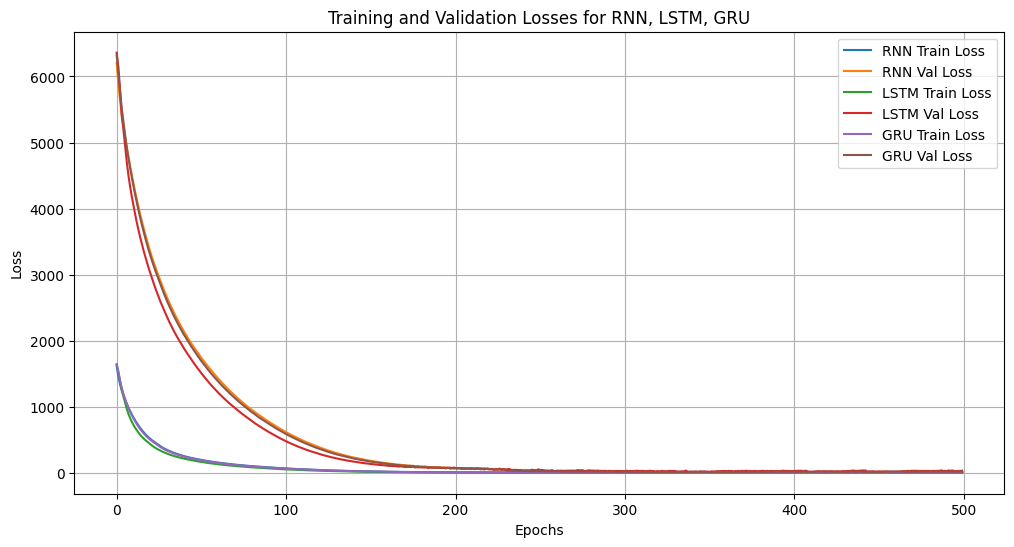

In [13]:
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = 500
criterion = nn.MSELoss()

def train_and_evaluate(model, optimizer, train_loader, val_loader, epochs, model_name):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * batch_x.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                val_outputs = model(batch_x)
                loss = criterion(val_outputs, batch_y)
                val_loss += loss.item() * batch_x.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        if (epoch + 1) % 5 == 0:
            print(f'[{model_name}] Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return train_losses, val_losses


rnn_model = RNNModel().to(device)
optimizer_rnn = optim.Adam(rnn_model.parameters(), lr=0.001)
rnn_train_losses, rnn_val_losses = train_and_evaluate(rnn_model, optimizer_rnn, train_loader, val_loader, epochs, "RNN")

lstm_model = LSTMModel().to(device)
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=0.001)
lstm_train_losses, lstm_val_losses = train_and_evaluate(lstm_model, optimizer_lstm, train_loader, val_loader, epochs, "LSTM")

gru_model = GRUModel().to(device)
optimizer_gru = optim.Adam(gru_model.parameters(), lr=0.001)
gru_train_losses, gru_val_losses = train_and_evaluate(gru_model, optimizer_gru, train_loader, val_loader, epochs, "GRU")

# 손실 시각화
plt.figure(figsize=(12, 6))
plt.plot(rnn_train_losses, label='RNN Train Loss')
plt.plot(rnn_val_losses, label='RNN Val Loss')
plt.plot(lstm_train_losses, label='LSTM Train Loss')
plt.plot(lstm_val_losses, label='LSTM Val Loss')
plt.plot(gru_train_losses, label='GRU Train Loss')
plt.plot(gru_val_losses, label='GRU Val Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses for RNN, LSTM, GRU')
plt.legend()
plt.grid()
plt.show()


In [14]:
rnn_model.eval()
test_loss_rnn = 0.0

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        predictions = rnn_model(batch_x)
        loss = criterion(predictions, batch_y)
        test_loss_rnn += loss.item() * batch_x.size(0)

test_loss_rnn /= len(test_loader.dataset)
print(f'[RNN] Test Loss: {test_loss_rnn:.4f}')

[RNN] Test Loss: 17.4748


In [15]:
lstm_model.eval()
test_loss_lstm = 0.0

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        predictions = lstm_model(batch_x)
        loss = criterion(predictions, batch_y)
        test_loss_lstm += loss.item() * batch_x.size(0)

test_loss_lstm /= len(test_loader.dataset)
print(f'[LSTM] Test Loss: {test_loss_lstm:.4f}')

[LSTM] Test Loss: 45.6425


In [16]:
gru_model.eval()
test_loss_gru = 0.0

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        predictions = gru_model(batch_x)
        loss = criterion(predictions, batch_y)
        test_loss_gru += loss.item() * batch_x.size(0)

test_loss_gru /= len(test_loader.dataset)
print(f'[GRU] Test Loss: {test_loss_gru:.4f}')

[GRU] Test Loss: 17.1514


# **ETH-USD 시계열 데이터 개요**

### **주요 특징**
#### **데이터 형태 및 구성**
- 이더리움(ETH)의 미국 달러(USD) 시세 데이터로 구성되어 있습니다.
- 각 데이터는 시간 순서에 따라 연속적으로 기록된 시계열 데이터입니다.
- Timestamp(시간 정보)는 제공되지 않으며, 단순히 연속적인 인덱스 순서에 따라 데이터가 나열되어 있습니다.
- 각 데이터 항목은 **하나의 수치(label)**로 표현되며, 이는 ETH의 특정 시점 가격을 의미합니다.

#### **데이터 크기**
- 716개의 데이터 개수를 가집니다.
- 현재 실험에서는 Train, Val, Test 비율을 0.8, 0.1, 0.1로 나누어 사용하였습니다.

# **데이터 생성**

#### **시퀀스 데이터 생성 함수 (create_sequences(data, seq_length))**
- 주어진 train data를 입력받아, seq_length 길이의 연속된 데이터로 입력 시퀀스를 만들고, 그 다음 값을 예측하도록 하는 **입출력 데이터(x, y)**를 생성하는 함수입니다.
- 단일 시점의 데이터만으로는 미래를 정확하게 예측하기 어려우므로, 연속된 여러 시점(seq_length)의 데이터를 입력으로 넣어 데이터 간의 시간적 흐름을 모델이 학습할 수 있도록 하기 위해 사용했습니다.

# **분석 및 고찰**

### 1. **모델 학습 결과**
  RNN, LSTM, GRU 세 모델 모두 학습 초반에 손실값이 빠르게 감소하며, 일정 에폭 이후에는 완만하게 줄어드는 경향을 보였습니다. 300 epoch까지 진행한 결과, Train Loss와 Val Loss 모두 안정적으로 수렴하는 모습을 확인할 수 있었습니다.
  그러나 Test Loss 평가 결과는 아래와 같았습니다

  RNN Test Loss: 17.4748

  GRU Test Loss: 17.1514

  LSTM Test Loss: 45.6425

### 2. **결론**
  동일한 hidden_dim(64), batch_size(32), epoch(500) 설정에서 RNN과 GRU가 좋은 Test Loss를 기록했습니다.
  이는 데이터의 패턴이 비교적 단기적인 흐름에 의해 결정되었기 때문이라고 판단됩니다. 반면, LSTM은 주어진 데이터에 비해 모델 구조가 지나치게 복잡하여 오히려 성능이 저하된 것으로 해석됩니다.